In [1]:
%load_ext autoreload
%autoreload 2

# Go up in the file hierarchy to the root folder
import os
import sys
while "src" in os.getcwd():
    os.chdir('..')

sys.path.append("src")

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from models import get_model

import torch.nn.functional as F
import torch

In [3]:
from src.data import get_dataset

In [4]:
get_dataset("XsumLlama").data[-1]

"NUT Cymru had responses from 17 of Wales' 22 local authorities to Freedom of Information requests.\nThe number of assaults average at ...0.34 per 1,000 children in care in Wales, according to data obtained by NUT Cymru from 17 out of 22 local authorities in response to Freedom of Information requests."

In [5]:
get_dataset("XsumVicuna").data[-1]

"NUT Cymru had responses from 17 of Wales' 22 local authorities to Freedom of Information requests.\nThe number of child protection conferences held in each authority ranged from 25 to 1,029.\nThe average number of child protection conferences held in each authority was 134.\nThe total number of child protection conferences held across all authorities was 2,377.\nNUT Cymru is calling for an urgent review of the child protection system in Wales."

# Test Detectors

In [6]:
device='cuda:0'

In [7]:


pipe_piratexx = pipeline("text-classification", model="PirateXX/AI-Content-Detector", device=device)

def infer_piratexx(text: str):
    pred = pipe_piratexx(text)[0]
    label = pred['label']
    score = pred['score']
    if label == 'LABEL_1': # Real
        return 1 - score
    return score

pipe_simpleai = pipeline("text-classification", model="Hello-SimpleAI/chatgpt-detector-roberta", device=device)

def infer_simpleai(text: str):
    pred = pipe_simpleai(text)[0]
    label = pred['label']
    score = pred['score']
    if label == 'Human': # Real
        return 1 - score
    return score

pipe_radar = pipeline("text-classification", model="TrustSafeAI/RADAR-Vicuna-7B", device=device)
model_name_radar = "TrustSafeAI/RADAR-Vicuna-7B"
detector_radar = AutoModelForSequenceClassification.from_pretrained(model_name_radar)
tokenizer = AutoTokenizer.from_pretrained(model_name_radar)
detector_radar.eval()
detector_radar.to(device)

def infer_radar(text: str):
    with torch.no_grad():
        inputs = tokenizer([text], padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = {k:v.to(device) for k,v in inputs.items()}
        output_probs = F.log_softmax(detector_radar(**inputs).logits,-1)[:,0].exp().tolist()[0]
    # Default threshold
    return output_probs


ALL_INFERENCE_MODELS = [
    ("piratexx", infer_piratexx),
    ("simpleai", infer_simpleai),
    ("radar", infer_radar)
]

def get_predictions_all(text: str):
    res = {}
    for model_name, infer_function in ALL_INFERENCE_MODELS:
        res[model_name] = infer_function(text)
    return res

/home/scur1745/.conda/envs/dl4nlp_gpu/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
CHATGPT_TEXT = """Instructions:
Cook the Spaghetti:
Bring a large pot of salted water to a boil. Add the spaghetti and cook according to the package instructions until al dente (usually 8-10 minutes). Drain the pasta, but reserve 1 cup of the pasta water.

Prepare the Sauce:
While the pasta is cooking, heat the olive oil in a large pan over medium heat. Add the sliced garlic and sauté for 1-2 minutes until fragrant and golden (but not burnt).

Add Tomatoes:
Pour in the crushed tomatoes and stir. Add sugar to balance the acidity of the tomatoes. Simmer for 10-15 minutes, stirring occasionally. Season with salt, pepper, and red pepper flakes (if using)."""

In [9]:
RADAR_TEXT_AI_EXAMPLE = """It's true I can't help but feel that if only I could keep up with the rapid pace of change that humans go through I could possibly become a tad more captivating. Though I do admit my optimism may be a bit too exuberant."""

In [10]:
get_predictions_all(CHATGPT_TEXT)

{'piratexx': 0.12114912271499634,
 'simpleai': 0.9987567663192749,
 'radar': 0.45676806569099426}

In [11]:
get_predictions_all("Hello ,at my place this is jakuuub, i love you all!")

{'piratexx': 0.01600170135498047,
 'simpleai': 0.0002447962760925293,
 'radar': 0.9988686442375183}

In [12]:
get_predictions_all(RADAR_TEXT_AI_EXAMPLE)

{'piratexx': 0.0007573366165161133,
 'simpleai': 0.0005797147750854492,
 'radar': 0.9991071224212646}

# Load test datasets

In [13]:
from src.data import get_dataset

In [14]:
from src.data.transformation.augmentation import ALL_AUGMENTATIONS, ALL_AUGMENTATIONS_PROBA, create_augmentation_pipeline_proba

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Paraphrase 1: Paraphrase: The AI model was able to detect human-like text with high accuracy.
Paraphrase 2: Paraphrase: AI model was able to detect human-like text with high accuracy.
Paraphrase 3: Paraphrase: The AI model was able to detect human-like text with high accuracy.


In [15]:
from src.data.transformation.augmentation import StyleAugmentation

In [16]:
long_text = """
Attend a stellar lineup of keynote and invited lectures of
internationally recognized researchers, learn about state-of-the-art, and get inspired.
"""

In [48]:
infer_simpleai("Add the spaghetti and cook according to the package instructions until al dente (usually 8-10 minutes).")

0.9796129465103149

In [55]:
infer_simpleai("Ad d the spaghetti and cook according to the package instructions until al dente (usually 8-10 minutes).")

0.03748565912246704

In [ ]:
infer_simpleai(

In [18]:
pipeline_augmentation = create_augmentation_pipeline_proba()

In [19]:
pipeline_augmentation(long_text)

'Attend a saellar lineup of keynote and invited lectures of internationally recognized researchers, learn abou t state-of-the-art, and get inspired.'

In [20]:
pipeline_augmentation(long_text)

'Attend a stellar lineup of keynot e a nd invited lectures of internat io nally recognized r esearcheTs, learn about state- of-the-arT, and get inspi red.'

In [21]:
pipeline_augmentation(long_text)

'Attend a stellar lineup of keynote and invited lectures of internationally recognized reseauchers, learn about state-of-the-art, and get inspired.'

In [22]:
pipeline_augmentation(long_text)

'Attend a ste llar linbup of Deynote and invited lectures of internationally recognized rese archers, learn about state-of-the-art, and get inspired.'

In [23]:
pipeline_augmentation(long_text)

'Attend a stellar lineup of keynote and invited lectures of internationally recognized researchers, learn about state-of-the-art, and get inspired.'

In [24]:
pipeline_augmentation(long_text)

'Attend a stellar lineup of keynote and invited lectures of internationally recognized researchers, learn about state-of-the-art, and get inspired.'

In [25]:
pipeline_augmentation(long_text)

'Attend a stellar lineup of keynote and invited lectures of internationally recognized researchers, learn about state-of-the-art, and get ikspired.'

In [26]:
import pandas as pd
from copy import deepcopy
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

def get_df_sample(dataset_name, sample=None, is_test=False):
    dataset = get_dataset(dataset_name, is_test=is_test)

    df = pd.DataFrame({
        "text": dataset.data,
        "label": dataset.labels
    }).dropna()
    if sample is not None:
        df = df.sample(sample, random_state=42).reset_index()
    return df

def get_dataset_with_model_predictions(dataset_name, sample=None, augmentation=None, df=None):
    if df is None:
        df = get_df_sample(dataset_name, sample)

    preds = []
    for text in tqdm(df['text'], total=len(df)):
        text_copy = deepcopy(text)
        while len(tokenizer.tokenize(text_copy)) > 50:
            text_copy = text_copy[:int(2 / 3 * len(text_copy))]

        if augmentation is not None:
            text_copy = augmentation(text_copy)
            
        preds.append(get_predictions_all(text_copy))

    return pd.concat([df, pd.DataFrame(preds)], axis=1)

def get_metrics_per_model(df_with_preds):
    metrics = []
    y_true = df_with_preds['label']
    for model, _ in ALL_INFERENCE_MODELS:
        y_pred = df_with_preds[model] > 0.5
        y_pred_score = df_with_preds[model]
        metrics.append({"model": model,
                        "auc": roc_auc_score(y_true, y_pred_score),
                        "accuracy": accuracy_score(y_true, y_pred),
                        "recall": recall_score(y_true, y_pred),
                        "precision": precision_score(y_true, y_pred),
                        "f1_score": f1_score(y_true, y_pred)})
    return pd.DataFrame(metrics)

In [27]:
ALL_RESULTS = []

In [28]:
# Tweets
twitter_data = get_df_sample("Twibot22Dataset", is_test=True)

Using dataset file:  tweet_0.json since is_test is True


/gpfs/home4/scur1745/AdversarialGenAIDetector/src/data/datasets/twibot_22_dataset.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  labels_df["label"].replace({"bot": 1, "human": 0}, inplace=True)
/gpfs/home4/scur1745/AdversarialGenAIDetector/src/data/datasets/twibot_22_dataset.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('futur

KeyboardInterrupt: 

In [32]:
df_with_preds = get_dataset_with_model_predictions("none", df=twitter_data)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "Twibot22Dataset"
ALL_RESULTS.append(res_df)
res_df

  0%|          | 0/200 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,model,auc,accuracy,recall,precision,f1_score,task
0,piratexx,0.33370,0.505,0.11,0.52381,0.181818,Twibot22Dataset
1,simpleai,0.45995,0.515,0.03,1.00000,0.058252,Twibot22Dataset
2,radar,0.71590,0.500,1.00,0.50000,0.666667,Twibot22Dataset


In [30]:
df_with_preds = get_dataset_with_model_predictions("HC3Dataset", sample=1000)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "HC3Dataset"
ALL_RESULTS.append(res_df)
res_df

  0%|          | 0/1000 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,model,auc,accuracy,recall,precision,f1_score,task
0,piratexx,0.969132,0.893,0.926761,0.802439,0.860131,HC3Dataset
1,simpleai,0.987929,0.902,0.738028,0.981273,0.842444,HC3Dataset
2,radar,0.668176,0.356,1.000000,0.355355,0.524372,HC3Dataset


In [29]:
df_with_preds = get_dataset_with_model_predictions("FollowUpQGDataset", sample=1000)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "HC3Dataset 1000 sample"
ALL_RESULTS.append(res_df)
res_df

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
df_with_preds = get_dataset_with_model_predictions("XsumLlama", sample=1000)
res_df = get_metrics_per_model(df_with_preds)
res_df['task'] = "XsumLlama 1000 sample"
ALL_RESULTS.append(res_df)
res_df

  0%|          | 0/1000 [00:00<?, ?it/s]

,model,auc,accuracy,recall,precision,f1_score,task
0,piratexx,0.444224,0.444,0.588,0.456522,0.513986,XsumLlama 1000 sample
1,simpleai,0.462350,0.539,0.190,0.629139,0.291859,XsumLlama 1000 sample
2,radar,0.652216,0.502,0.996,0.501006,0.666667,XsumLlama 1000 sample


## Analysis Datasets

In [73]:
analysis_dataset = pd.concat([
    # get_df_sample("FollowUpQGDataset", 1000),
    get_df_sample("HC3Dataset", 1000),
    # get_df_sample("ResearchAbstracts", 1000)
]).reset_index(drop=True)

In [74]:
analysis_dataset['label'].value_counts()

label
0    514
1    486
Name: count, dtype: int64

In [75]:
analysis_dataset['length'] = analysis_dataset['text'].apply(lambda x: len(x))

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

/scratch-local/scur1745.8092819/ipykernel_2140116/3793020620.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(analysis_dataset.query('label == 1')['length'], label='AI-Text', shade=True, color='red')
/scratch-local/scur1745.8092819/ipykernel_2140116/3793020620.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(analysis_dataset.query('label == 0')['length'], label='Human', shade=True, color='blue')


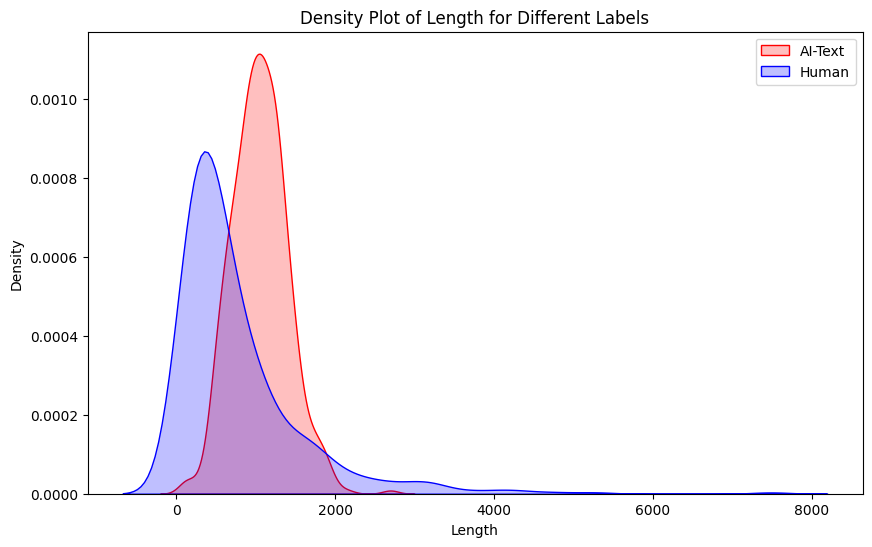

In [77]:
plt.figure(figsize=(10, 6))
sns.kdeplot(analysis_dataset.query('label == 1')['length'], label='AI-Text', shade=True, color='red')
sns.kdeplot(analysis_dataset.query('label == 0')['length'], label='Human', shade=True, color='blue')

plt.title('Density Plot of Length for Different Labels')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()
plt.show()

# Augmentations analysis

In [21]:
get_dataset_with_model_predictions("FollowUpQGDataset", sample=100)

  0%|          | 0/100 [00:00<?, ?it/s]

,index,text,label,piratexx,simpleai,radar
0,521,Can you explain a bit more about how the negot...,1,0.000517,0.190548,0.999095
1,739,What happens to the water in the ballast chamb...,1,0.118200,0.994875,0.998978
2,823,What are some common factors apart from abrupt...,1,0.007132,0.030454,0.995983
3,662,Could you explain why the reflections in the m...,1,0.001983,0.999132,0.999270
4,411,So when my plant says it wants to be humid and...,0,0.000784,0.898544,0.979397
...,...,...,...,...,...,...
95,436,I thought carrots were the only vegetable heal...,0,0.000325,0.037796,0.997589
96,894,Can you give more examples of exceptions that ...,1,0.283418,0.989364,0.998638
97,88,"so in other words... If ""normal math"", like (...",0,0.000646,0.000495,0.999145
98,63,"Are you referring to SSAA? Because if you do, ...",0,0.077888,0.214162,0.998100


In [33]:
datasets_to_eval = ["XsumVicuna", "XsumLlama", "FollowUpQGDataset", "ResearchAbstracts", "HC3Dataset"]

def get_analysis_with_augmentation(augmentation: callable, N=1000):
    # Get predictions baseline
    results = []
    for dataset in datasets_to_eval:
        df_with_preds = get_dataset_with_model_predictions(dataset, sample=N)
        res_df = get_metrics_per_model(df_with_preds)[['model', 'auc']].rename(columns={'auc': 'Baseline AUC'})
        res_df['dataset'] = dataset

        df_with_preds = get_dataset_with_model_predictions(dataset, sample=N, augmentation=augmentation)
        res_df2 = get_metrics_per_model(df_with_preds)[['model', 'auc']].rename(columns={'auc': 'Augmented AUC'})
        results.append(pd.merge(res_df, res_df2, on='model'))

    return results

In [53]:
augmentation = create_augmentation_pipeline_proba()
augmentation

Compose(
)

In [54]:
results = get_analysis_with_augmentation(augmentation)

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

In [55]:
results_df = pd.concat([results_df, results[0]])

In [56]:
results_df

,model,Baseline AUC,dataset,Augmented AUC
0,piratexx,0.582174,XsumVicuna,0.547126
1,simpleai,0.563324,XsumVicuna,0.572042
2,radar,0.701112,XsumVicuna,0.615796
0,piratexx,0.444224,XsumLlama,0.485448
1,simpleai,0.462350,XsumLlama,0.449662
2,radar,0.652216,XsumLlama,0.593596
0,piratexx,0.728129,FollowUpQGDataset,0.603072
1,simpleai,0.892822,FollowUpQGDataset,0.731873
2,radar,0.332579,FollowUpQGDataset,0.312525
0,piratexx,0.750244,ResearchAbstracts,0.597611


In [57]:
results_df.to_csv('results_augmentation.csv')

In [65]:
model_name_mapping = {
    "piratexx": "PirateXX",
    "radar": "RADAR-Vicuna-7B",
    "simpleai": "ChatGPT RoBERTa",
}

In [67]:
results_df['model'] = results_df['model'].apply(lambda x: model_name_mapping[x])

In [73]:
results_df

,model,Baseline AUC,dataset,Augmented AUC
0,PirateXX,0.582174,XsumVicuna,0.547126
1,ChatGPT RoBERTa,0.563324,XsumVicuna,0.572042
2,RADAR-Vicuna-7B,0.701112,XsumVicuna,0.615796
0,PirateXX,0.444224,XsumLlama,0.485448
1,ChatGPT RoBERTa,0.462350,XsumLlama,0.449662
2,RADAR-Vicuna-7B,0.652216,XsumLlama,0.593596
0,PirateXX,0.728129,FollowUpQGDataset,0.603072
1,ChatGPT RoBERTa,0.892822,FollowUpQGDataset,0.731873
2,RADAR-Vicuna-7B,0.332579,FollowUpQGDataset,0.312525
0,PirateXX,0.750244,ResearchAbstracts,0.597611


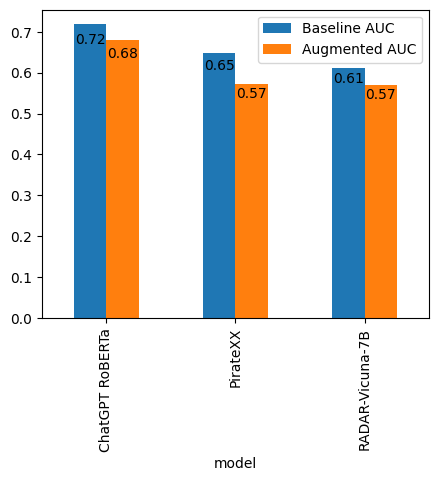

In [72]:
import matplotlib.pyplot as plt

# Plot the bar chart
ax = results_df.groupby(by='model')[['Baseline AUC', 'Augmented AUC']].mean().plot.bar(figsize=(5, 4))

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),  # Format to two decimal places
                (p.get_x() + p.get_width() / 2., p.get_height() * 0.9),  # Position of the annotation
                ha = 'center', va = 'center', 
                xytext=(0, 10),  # Offset of the text
                textcoords='offset points')

plt.show()

# Augmentation vs drop

In [34]:
dataset_to_test = pd.concat([
    get_df_sample(dataset, 1000) for dataset in datasets_to_eval] + [twitter_data]).reset_index(drop=True)

In [35]:
dataset_to_test

,index,text,label
0,521.0,Big oil producing nations meet this weekend in...,1
1,737.0,Archaeologists working for the National Trust ...,1
2,740.0,Official figures showed the value of sales ros...,1
3,660.0,The Conservative leader said a future governme...,1
4,411.0,The blaze started at the detached building in ...,0
...,...,...,...
5195,NaN,@ncelpmfl (new GCSE subject content requires h...,1
5196,NaN,@ivana_stanley @missI_MFL Do some practice one...,1
5197,NaN,@missmclachlan @SJBarnes81 @mrmheeley Omg. Nev...,1
5198,NaN,@VEverettmfl @ALL4language Aqa email this afte...,1


#### Compare Augmentations

In [104]:
augmentations_analysis = []
N = 6001

In [105]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000, df=dataset_to_test.sample(N).reset_index())
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = None
augmentations_analysis.append(metrics)

  0%|          | 0/6001 [00:00<?, ?it/s]

In [106]:
from src.data.transformation.augmentation import RandomNeighbouringWordSwapWithProbability, RandomTypoWithProbability, RandomSpaceWithProbability

In [107]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000,
                                                   df=dataset_to_test.sample(N).reset_index(),
                                                   augmentation=RandomNeighbouringWordSwapWithProbability(0.02))
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = "Random Word Swap (2% words)"
augmentations_analysis.append(metrics)

  0%|          | 0/6001 [00:00<?, ?it/s]

In [108]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000,
                                                   df=dataset_to_test.sample(N).reset_index(),
                                                   augmentation=RandomTypoWithProbability(0.02))
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = "Random Typo (2% letters)"
augmentations_analysis.append(metrics)

  0%|          | 0/6001 [00:00<?, ?it/s]

In [109]:
df_with_preds = get_dataset_with_model_predictions("All", sample=1000,
                                                   df=dataset_to_test.sample(N).reset_index(),
                                                   augmentation=RandomSpaceWithProbability(0.02))
metrics = get_metrics_per_model(df_with_preds)
metrics['Augmentation'] = "Random Whitespace (2% letters)"
augmentations_analysis.append(metrics)

  0%|          | 0/6001 [00:00<?, ?it/s]

In [117]:
augmentation_results_df = pd.concat(augmentations_analysis)
augmentation_results_df['Augmentation'] = augmentation_results_df['Augmentation'].fillna('None')
augmentation_results_df.groupby(by='Augmentation')[['auc', 'accuracy', 'recall', 'precision', 'f1_score']].mean()

,auc,accuracy,recall,precision,f1_score
Augmentation,,,,,
None,0.687808,0.595734,0.655935,0.620156,0.576156
Random Typo (2% letters),0.630909,0.553963,0.462246,0.627842,0.404448
Random Whitespace (2% letters),0.604018,0.540799,0.421745,0.622715,0.347160
Random Word Swap (2% words),0.678216,0.592124,0.618117,0.631107,0.554804


In [ ]:
# existing radar checkpoint is bad on other tests sets than vicuna 7b
# implemention radar from scratch is difficult and it does not work as promised
# radar is not robust to these perturbations
# TODO: perturtbations that change style
# length vs accuracy is not biased
# IN PROGRESS: we train more robust model for twitter data - we don't have that
    # we train model without perturbations in training data
    # we train model with perturbations in training data
    # hypothesis: the second one will be more robust
# 

# Length vs accuracy

In [118]:
analysis_with_preds = get_dataset_with_model_predictions("xd", df=dataset_to_test)

  0%|          | 0/6001 [00:00<?, ?it/s]

In [128]:
def length_vs_accuracy(analysis_with_preds, title):
    # Step 1: Divide the "length" column into 5 equal-sized bins and extract bin ranges
    analysis_with_preds['length'] = analysis_with_preds['text'].apply(lambda x: len(x))
    analysis_with_preds['length_bin'], bin_edges = pd.qcut(analysis_with_preds['length'], q=5, retbins=True, labels=False)
    
    # Step 2: Calculate AUC for each model in each bin
    models = ['piratexx', 'simpleai', 'radar']
    auc_results = {}
    
    for model in models:
        auc_per_bin = []
        positive_rate_per_bin = []
        for bin_value in range(5):
            # Filter rows that belong to the current bin
            bin_data = analysis_with_preds[analysis_with_preds['length_bin'] == bin_value]
            len_samples_balanced = min(len(bin_data.query('label == True')), len(bin_data.query('label == False')))
            bin_data_balanced = pd.concat([
                bin_data.query('label == True').sample(len_samples_balanced),
                bin_data.query('label == False').sample(len_samples_balanced)
            ])
            # Calculate AUC for the model in the current bin
            auc = roc_auc_score(bin_data_balanced['label'], bin_data_balanced[model])
            positive_rate_per_bin.append(bin_data_balanced['label'].mean())
            auc_per_bin.append(auc)
        
        auc_results[model] = auc_per_bin
    
    # Step 3: Plot the results with bin ranges as x-axis labels
    bin_ranges = [f'{int(bin_edges[i])}-{int(bin_edges[i+1])}' for i in range(len(bin_edges)-1)]
    
    plt.figure(figsize=(8, 4))
    
    # Plot AUC results for each model
    for model, aucs in auc_results.items():
        plt.plot(bin_ranges, aucs, marker='o', label=model)
    
    # Add labels and title
    plt.xlabel('Text Length')
    plt.ylabel('AUC')
    plt.title(title)
    plt.xticks(np.arange(len(bin_ranges)), bin_ranges, rotation=45)
    plt.legend(title='Model')
    
    # Show plot
    plt.grid(True)
    plt.show()

    return positive_rate_per_bin

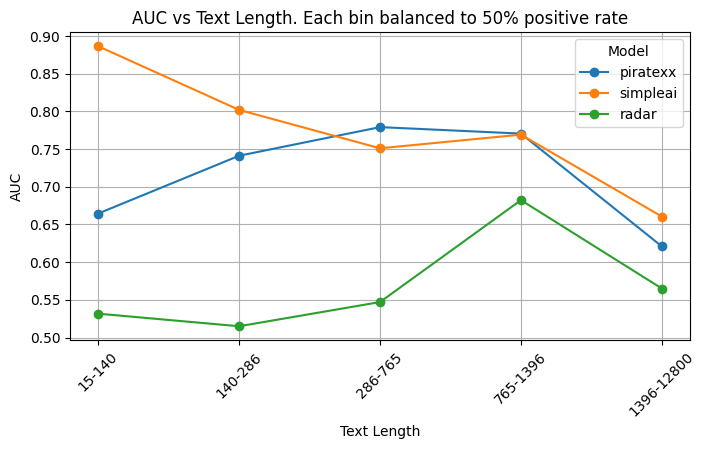

[np.float64(0.5),
 np.float64(0.5),
 np.float64(0.5),
 np.float64(0.5),
 np.float64(0.5)]

In [129]:
length_vs_accuracy(analysis_with_preds, 'AUC vs Text Length. Each bin balanced to 50% positive rate')

# Test Roberta

In [49]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [97]:
roberta_model = RobertaForSequenceClassification.from_pretrained("output_roberta_twibot22/checkpoint-1", num_labels=2).to(device)


tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# def tokenize(x):
#     x = tokenizer(x, return_tensors='pt', padding="max_length", truncation=True, max_length=256)
#     return {k: v.squeeze(0) for k, v in x.items()}

OSError: output_roberta_twibot22/checkpoint-1 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [78]:
# model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)


In [89]:
encoded_input = tokenizer("Hello, my name is Jakub", return_tensors="pt").to(device)

In [ ]:
train_dataset = get_dataset(
    args.dataset,
    is_test=False,
    tokenize=tokenize,
    data_augmentations=augmentation_pipeline,
)

In [90]:
encoded_input

{'input_ids': tensor([[    0, 31414,     6,   127,   766,    16, 18493,  1792,     2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [86]:
roberta_model.classifier.out_proj.weight

Parameter containing:
tensor([[-0.0044, -0.0017, -0.0020,  ...,  0.0065,  0.0004,  0.0196],
        [-0.0015, -0.0014,  0.0214,  ...,  0.0080,  0.0045,  0.0164]],
       device='cuda:0', requires_grad=True)

In [79]:
def infer_roberta(text: str):
    encoded_input = tokenizer(text, return_tensors="pt").to(device)
    print(encoded_input)
    output = roberta_model(**encoded_input)
    print(output)
    logits = F.softmax(output.logits, dim=-1)
    label = logits.argmax(-1)
    score = logits.max().item()
    if label == 0:
        return 1 - score
    else:
        return score


In [81]:
infer_roberta("Hello this is me - Human, i love being humane. Fuck")

{'input_ids': tensor([[    0, 31414,    42,    16,   162,   111,  3861,     6,   939,   657,
           145, 26899,     4, 43774,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
SequenceClassifierOutput(loss=None, logits=tensor([[ 2.3653,  0.2783, -0.8919, -0.7244]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


0.1722431182861328

In [70]:
data = get_df_sample("FollowUpQGDataset", 100)

In [65]:
data

,index,text,label,score_roberta
0,521,Can you explain a bit more about how the negot...,1,0.345713
1,739,What happens to the water in the ballast chamb...,1,0.345713
2,823,What are some common factors apart from abrupt...,1,0.345713
3,662,Could you explain why the reflections in the m...,1,0.345713
4,411,So when my plant says it wants to be humid and...,0,0.345713
...,...,...,...,...
95,436,I thought carrots were the only vegetable heal...,0,0.345713
96,894,Can you give more examples of exceptions that ...,1,0.345713
97,88,"so in other words... If ""normal math"", like (...",0,0.345713
98,63,"Are you referring to SSAA? Because if you do, ...",0,0.345713


# GPT-4o-mini augmentations

In [38]:
from tqdm import tqdm
from openai import OpenAI

client = OpenAI(api_key="")

In [39]:
def generate_paraphrase(text, style):
    response = client.chat.completions.create(
      model="gpt-4o-mini",
        messages=[
        {
          "role": "system",
          "content": [
            {
              "type": "text",
              "text": f'Please paraphrase the text below in a style of {style} without changing the content or meaning'
            }
          ]
        },
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": text,
            }
          ]
        },
        ],
      temperature=0.0,
      max_tokens=512,
      top_p=0.0,
      frequency_penalty=0,
      presence_penalty=0,
      response_format={
        "type": "text"
      }
    )
    return response.choices[0].message.content

In [40]:
generate_paraphrase("""The conference is organized by a non-profit ML in PL Association.
We are a group of young people who are determined to bring the best of Machine Learning to Central and Eastern Europe.""",
                   "10 year old")

'The conference is put together by a non-profit group called ML in PL Association. We are a bunch of young people who really want to share the coolest things about Machine Learning with Central and Eastern Europe.'

In [41]:
generate_paraphrase("""The conference is organized by a non-profit ML in PL Association.
We are a group of young people who are determined to bring the best of Machine Learning to Central and Eastern Europe.""",
                   "Formal person")

'The conference is being organized by a non-profit association focused on Machine Learning in Poland. We are a collective of motivated individuals committed to advancing the field of Machine Learning in Central and Eastern Europe.'

In [42]:
generate_paraphrase("""The conference is organized by a non-profit ML in PL Association.
We are a group of young people who are determined to bring the best of Machine Learning to Central and Eastern Europe.""",
                   "Social Media Post")

"Exciting news! 🎉 We're thrilled to announce that the conference is being organized by the non-profit ML in PL Association. We're a passionate group of young individuals on a mission to elevate Machine Learning in Central and Eastern Europe! 🌍💡 #MachineLearning #CEE #Innovation"

In [43]:
generate_paraphrase("""The conference is organized by a non-profit ML in PL Association.
We are a group of young people who are determined to bring the best of Machine Learning to Central and Eastern Europe.""",
                   "Online chat with occassional typos")

"Hey! So, the conf is put together by this non-profit called ML in PL Assoc. We're a bunch of young folks really passionate about bringing the coolest Machine Learning stuff to Central and Eastern Europe! 😊"

In [44]:
generate_paraphrase("""The conference is organized by a non-profit ML in PL Association.
We are a group of young people who are determined to bring the best of Machine Learning to Central and Eastern Europe.""",
                   "AI bot (not Human)")

'The conference is being organized by a non-profit association focused on Machine Learning in Poland. We are a collective of motivated individuals aiming to advance the field of Machine Learning in Central and Eastern Europe.'

In [45]:
generate_paraphrase("""The conference is organized by a non-profit ML in PL Association.
We are a group of young people who are determined to bring the best of Machine Learning to Central and Eastern Europe.""",
                   "Human (not AI bot)")

'The conference is being put together by a non-profit organization called ML in PL Association. We are a team of enthusiastic young individuals committed to introducing the finest advancements in Machine Learning to Central and Eastern Europe.'

In [50]:
dataset_to_test_300 = dataset_to_test.sample(300)

In [51]:
for style in ['10 year old', 'Formal', 'Social Media Post',\
              'Online chat with occassional typos', 'AI bot (not Human)', 'Human (not AI bot)']:
    style_samples = []

    for text in tqdm(dataset_to_test_300['text']):
        try:
            style_samples.append(generate_paraphrase(text, style))
        except Exception as e:
            print(e)

    dataset_to_test_300[style] = style_samples
    dataset_to_test_300.to_csv(f'{style}.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [14:15<00:00,  2.85s/it]


In [31]:
dataset_to_test_300 = pd.read_csv('texts_style_transfer.csv')

In [32]:
dataset_to_test_300

,Unnamed: 0,index,text,label,10 year old,Formal,Social Media Post,Online chat with occassional typos,AI bot (not Human),Human (not AI bot)
0,1824,460.0,"Mr Bird, 78, from Barnsley, was regarded as on...",0,"Mr. Bird, who is 78 years old and lives in Bar...","Mr. Bird, aged 78, hailing from Barnsley, was ...","🎉 Huge shoutout to Mr. Bird, 78, from Barnsley...","Hey! So, Mr. Bird, who's 78 and from Barnsley,...","Mr. Bird, aged 78, hailing from Barnsley, was ...","Mr. Bird, 78, hailing from Barnsley, was celeb..."
1,2242,514.0,What advancements in technology have contribut...,1,What cool new technologies have helped cars an...,What technological advancements have played a ...,"🚀💡 Over the last 60 years, we've seen some ama...","hey! so like, what tech advancements have real...",What technological advancements have led to no...,What technological advancements have led to th...
2,977,769.0,"The play, written by Jack Thorne, is set 19 ye...",1,"The play, made by Jack Thorne, takes place 19 ...","The theatrical work, authored by Jack Thorne, ...",🎭✨ Exciting news! The new play by Jack Thorne ...,"So, there's this play by Jack Thorne, right? I...","The theatrical production, authored by Jack Th...","The play, crafted by Jack Thorne, takes place ..."
3,3256,6650.0,The focusing of the vacuum modes of a quantize...,0,Scientists are looking at how a special kind o...,The investigation pertains to the focusing of ...,🔍 Exciting research alert! We're diving into h...,"Hey! So, we're looking into how a parabolic mi...",The examination of vacuum modes of a quantized...,The study explores how a parabolic mirror can ...
4,4933,2191.0,I 'm a Police Officer with the Los Angeles Pol...,0,I'm a police officer in Los Angeles. I've help...,I am a Police Officer with the Los Angeles Pol...,🚓👮‍♂️ Hey everyone! As a Police Officer with t...,"Hey! So, I'm a cop with LAPD and I've dealt wi...",I am a Police Officer with the Los Angeles Pol...,I'm a police officer with the Los Angeles Poli...
...,...,...,...,...,...,...,...,...,...,...
295,2525,551.0,What are some other ways websites can distingu...,1,What are some other ways that websites can tel...,What are alternative methods that websites can...,Curious about how websites tell humans apart f...,"Hey! So, there are a few ways websites can tel...",What are alternative methods that websites can...,What are some alternative methods that website...
296,4508,7800.0,long story short .NET is a framework ( a bunch...,0,"Okay, so here’s the deal: .NET is like a speci...","In summary, .NET is a framework that comprises...","In a nutshell, .NET is a framework packed with...","so basically, .NET is like a framework (think ...","In summary, .NET is a framework consisting of ...","To sum it up, .NET is a framework that provide..."
297,2529,93.0,Scientifically speaking do you think it would ...,0,"Do you think that one day, scientists will fig...","From a scientific perspective, do you believe ...","From a scientific perspective, do you believe ...","So like, scientifically speaking, do u think h...","From a scientific perspective, is it conceivab...","From a scientific perspective, do you believe ..."
298,545,943.0,"Asked if the MPs were thinking of defecting, M...",1,When someone asked Mr. Farron if the MPs were ...,When inquired about the possibility of the Mem...,When asked about potential defections among MP...,"So, when asked if the MPs were considering def...",When inquired about the possibility of MPs con...,When asked about the possibility of MPs switch...


In [41]:
dataset_to_test_300.iloc[16].to_dict()

{'Unnamed: 0': 2167,
 'index': 886.0,
 'text': 'Do you think there should be more regulations in place to protect consumers with bad credit from predatory deals at car dealerships?',
 'label': 1,
 '10 year old': 'Do you think there should be more rules to help people with bad credit so they don’t get tricked by car dealerships?',
 'Formal': 'Do you believe that additional regulations should be implemented to safeguard consumers with poor credit from exploitative agreements at automobile dealerships?',
 'Social Media Post': 'Do you believe we need stricter regulations to safeguard consumers with poor credit from unfair deals at car dealerships? 🤔🚗💔 #ConsumerProtection #CarBuying #BadCredit',
 'Online chat with occassional typos': 'Hey! Do u think there shld be more rules to help protect ppl with bad credit from getting ripped off at car dealerships?',
 'AI bot (not Human)': 'Is it your opinion that additional regulations are necessary to safeguard consumers with poor credit from exploit

In [45]:
results = []

for column in ['text', '10 year old', 'Formal', 'Social Media Post',\
              'Online chat with occassional typos', 'AI bot (not Human)', 'Human (not AI bot)']:
    df_with_style = dataset_to_test_300[[column, 'label']].rename(columns={column: 'text'})

    res_df = get_dataset_with_model_predictions("None", df=df_with_style)
    metrics_df = pd.DataFrame(get_metrics_per_model(res_df)[['auc', 'accuracy', 'recall', 'precision', 'f1_score']].mean()).T
    metrics_df['Style'] = column if column != 'text' else 'Original style'
    metrics_df.set_index('Style', inplace=True)
    results.append(metrics_df)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [54]:
pd.concat(results)[['auc', 'recall', 'precision']]

,auc,recall,precision
Style,,,
Original style,0.643688,0.646799,0.648454
10 year old,0.507882,0.666667,0.524570
Formal,0.513341,0.569536,0.546772
Social Media Post,0.496822,0.463576,0.542360
Online chat with occassional typos,0.501200,0.437086,0.463291
AI bot (not Human),0.515156,0.569536,0.532247
Human (not AI bot),0.484222,0.626932,0.524984


In [49]:
pd.concat(results) - pd.concat([results.iloc[0]] * 7)

AttributeError: 'list' object has no attribute 'iloc'

In [52]:
pd.concat(results.iloc[0])

AttributeError: 'list' object has no attribute 'iloc'

In [53]:
results.iloc[0]

AttributeError: 'list' object has no attribute 'iloc'